<a href="https://colab.research.google.com/github/AImSecure/Laboratory3/blob/main/lab/notebooks/Lab3_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3 — Anomaly Detection

text

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:


# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory3'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/


In [8]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {save_path}")

## Task 1 — Dataset Characterization and Preprocessing

text


In [9]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Explore the dataset

Before preprocessing, we explore the data to understand the available features.

In [10]:
# --- Load Datasets ---

train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

print("Files loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape:  {test_df.shape}")

Files loaded successfully.
Train dataset shape: (18831, 43)
Test dataset shape:  (5826, 43)


In [11]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10  num_failed_logins            18831 non-null  int64  
 11  logged_in                    18831 non-null  int64  
 12  num_compromised              18831 non-null  int64  
 13  root_shell      

In [13]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     5826 non-null   int64  
 1   protocol_type                5826 non-null   object 
 2   service                      5826 non-null   object 
 3   flag                         5826 non-null   object 
 4   src_bytes                    5826 non-null   int64  
 5   dst_bytes                    5826 non-null   int64  
 6   land                         5826 non-null   int64  
 7   wrong_fragment               5826 non-null   int64  
 8   urgent                       5826 non-null   int64  
 9   hot                          5826 non-null   int64  
 10  num_failed_logins            5826 non-null   int64  
 11  logged_in                    5826 non-null   int64  
 12  num_compromised              5826 non-null   int64  
 13  root_shell        

In [15]:
# --- Identify Categorical and Numerical Features ---

# We exclude the label columns from the feature lists
label_cols = ['label', 'binary_label']

# Identify categorical columns (type 'object')
categorical_cols = train_df.select_dtypes(include=['object']).columns.drop(label_cols, errors='ignore').to_list()

# Identify numerical columns (any number type)
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(label_cols, errors='ignore').to_list()

print(f"\n--- Feature Types ---")
print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} (First 5: {numerical_cols[:5]}...)")
print(f"Label features: {label_cols}")


--- Feature Types ---
Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: 38 (First 5: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']...)
Label features: ['label', 'binary_label']


In [16]:
# --- Check Label Distribution ---
print("\n--- Attack Label Distribution (Train) ---")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Train) ---")
print(train_df['binary_label'].value_counts(normalize=True) * 100)

print("\n--- Attack Label Distribution (Test) ---")
print(test_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Test) ---")
print(test_df['binary_label'].value_counts(normalize=True) * 100)


--- Attack Label Distribution (Train) ---
label
normal    71.414158
dos       15.469173
probe     12.155488
r2l        0.961181
Name: proportion, dtype: float64

--- Binary Label Distribution (Train) ---
binary_label
0    71.414158
1    28.585842
Name: proportion, dtype: float64

--- Attack Label Distribution (Test) ---
label
dos       44.232750
normal    36.937865
probe     18.829386
Name: proportion, dtype: float64

--- Binary Label Distribution (Test) ---
binary_label
1    63.062135
0    36.937865
Name: proportion, dtype: float64


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_multiclass_label_distribution.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_binary_label_distribution.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_multiclass_label_distribution.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_binary_label_distribution.png


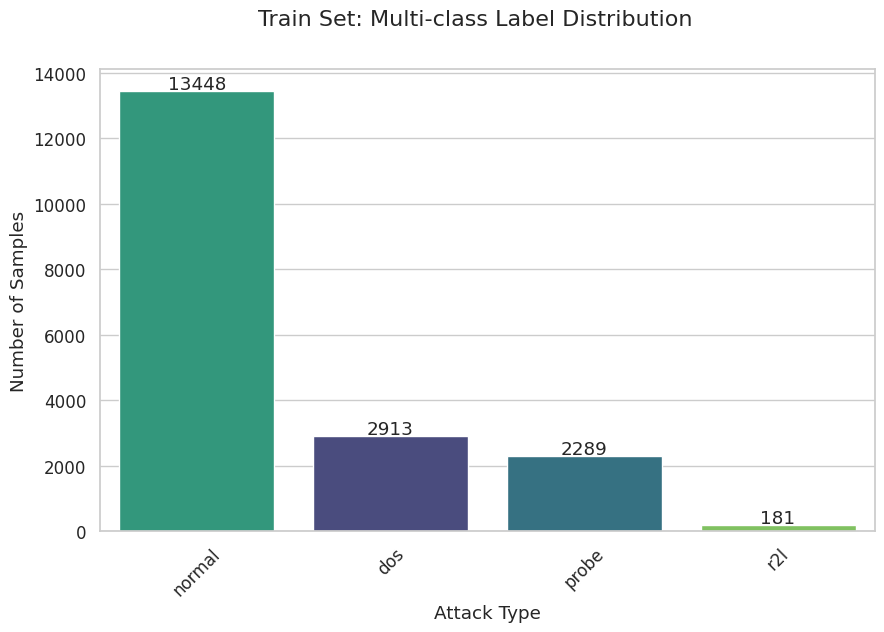

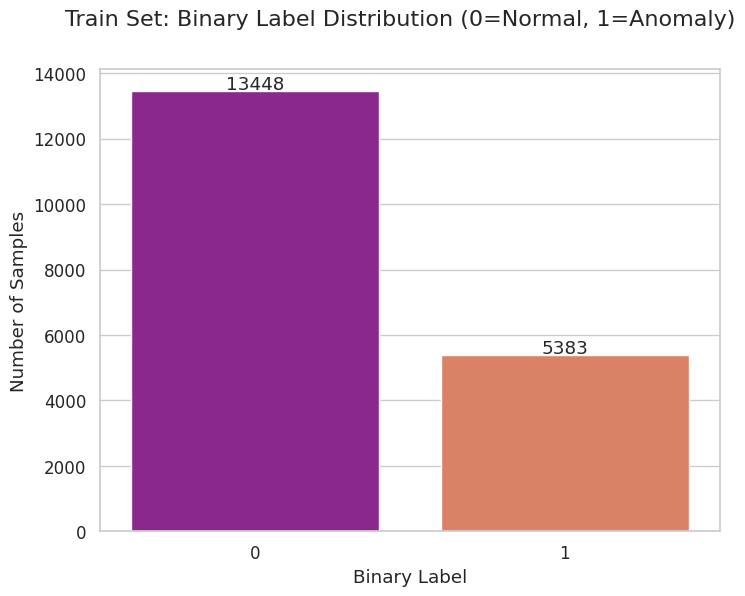

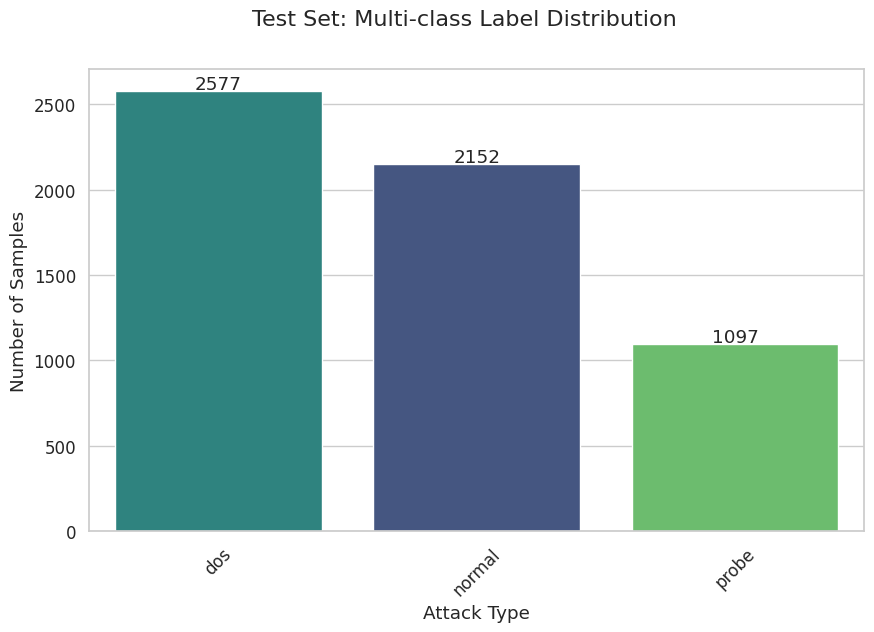

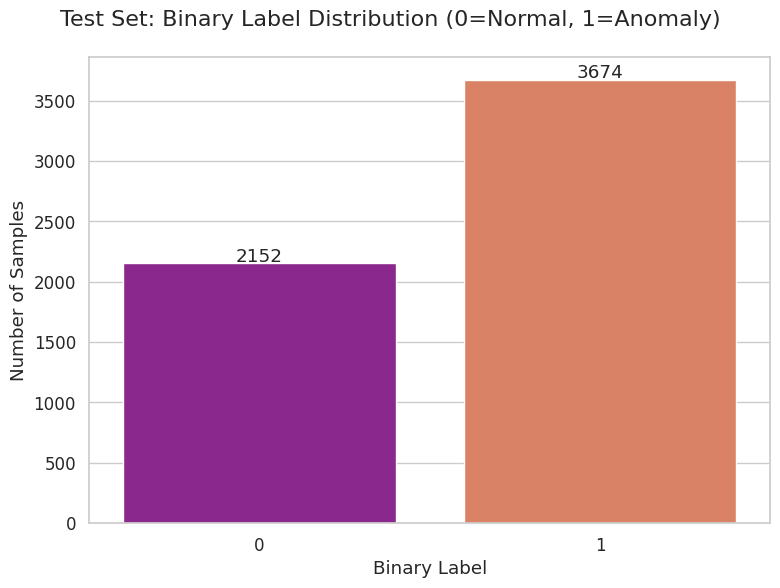

In [17]:
# Helper function to add count labels on bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

# Train Set - Multi-class Label Distribution
fig1, ax1 = plt.subplots(figsize=(10, 6))
fig1.suptitle('Train Set: Multi-class Label Distribution', fontsize=16)
sns.countplot(data=train_df, x='label', ax=ax1, palette='viridis', order=train_df['label'].value_counts().index, hue='label', legend=False)
ax1.set_xlabel('Attack Type')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)
add_counts(ax1)
save_plot(fig1, 'train_multiclass_label_distribution', path=save_dir, close_fig=False)

# Train Set - Binary Label Distribution
fig2, ax2 = plt.subplots(figsize=(8, 6))
fig2.suptitle('Train Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
sns.countplot(data=train_df, x='binary_label', ax=ax2, palette='plasma', hue='binary_label', legend=False)
ax2.set_xlabel('Binary Label')
ax2.set_ylabel('Number of Samples')
add_counts(ax2)
save_plot(fig2, 'train_binary_label_distribution', path=save_dir, close_fig=False)

# Test Set - Multi-class Label Distribution
fig3, ax3 = plt.subplots(figsize=(10, 6))
fig3.suptitle('Test Set: Multi-class Label Distribution', fontsize=16)
sns.countplot(data=test_df, x='label', ax=ax3, palette='viridis', order=test_df['label'].value_counts().index, hue='label', legend=False)
ax3.set_xlabel('Attack Type')
ax3.set_ylabel('Number of Samples')
ax3.tick_params(axis='x', rotation=45)
add_counts(ax3)
save_plot(fig3, 'test_multiclass_label_distribution', path=save_dir, close_fig=False)

# Test Set - Binary Label Distribution
fig4, ax4 = plt.subplots(figsize=(8, 6))
fig4.suptitle('Test Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
sns.countplot(data=test_df, x='binary_label', ax=ax4, palette='plasma', hue='binary_label', legend=False)
ax4.set_xlabel('Binary Label')
ax4.set_ylabel('Number of Samples')
add_counts(ax4)
save_plot(fig4, 'test_binary_label_distribution', path=save_dir, close_fig=False)

plt.tight_layout()

#### Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?

The dataset characteristics are as follows:

- **Dataset Shape**: The training dataset `train_df` has 18,831 rows and 43 columns, while the testing dataset `test_df` has 5,826 rows and 43 columns.

- **Attribute Types**:
  - There are **3 categorical features**: `protocol_type`, `service`, and `flag`.
  - There are **38 numerical features**.
  - The label features are `label` and `binary_label`.

- **Attack Label Distribution (Train Set)**:
  - `normal`: 71.41%
  - `dos`: 15.47%
  - `probe`: 12.16%
  - `r2l`: 0.96%

- **Binary Label Distribution (Train Set)**:
  - `normal (0)`: 71.41%
  - `anomaly (1)`: 28.59%

- **Attack Label Distribution (Test Set)**:
  - `dos`: 44.23%
  - `normal`: 36.94%
  - `probe`: 18.83%

- **Binary Label Distribution (Test Set)**:
  - `anomaly (1)`: 63.06%
  - `normal (0)`: 36.94%

### Preprocessing

Preprocess features before performing any AI/ML algorithms.

In [18]:
# Create independent copies to ensure we don't modify the original dataframes
train_proc_df = train_df.copy()
test_proc_df = test_df.copy()

# Separate labels immediately to prevent labels scaling/encoding
# We extract both the multi-class ('label') and binary ('binary_label') targets
y_train_full_attack = train_proc_df.pop('label')
y_train_full_binary = train_proc_df.pop('binary_label')

y_test_attack = test_proc_df.pop('label')
y_test_binary = test_proc_df.pop('binary_label')

In [19]:
# Remove duplicates
print("Number of rows before operations:", train_proc_df.shape[0])
train_proc_df = train_proc_df.drop_duplicates()
print("Number of rows after duplicates:", train_proc_df.shape[0])

# Remove rows with missing values
train_proc_df = train_proc_df.dropna()
print("Number of rows after missing values:", train_proc_df.shape[0])

# Now drop the instances with inifinite values
train_proc_df = train_proc_df.replace([np.inf, -np.inf], np.nan).dropna()
print("Number of rows after removing infinite values:", train_proc_df.shape[0])

Number of rows before operations: 18831
Number of rows after duplicates: 18830
Number of rows after missing values: 18830
Number of rows after removing infinite values: 18830


In [20]:
print(f"Initial Feature Count: {train_proc_df.shape[1]}")

Initial Feature Count: 41


In [21]:
# --- Feature Selection: Drop Zero-Variance Columns ---

# Columns with 0 variance (all values are the same) provide no information to the model.
cols_to_drop = []
for col in numerical_cols:
    if train_proc_df[col].std() == 0:
        cols_to_drop.append(col)

# Drop them from both sets
train_proc_df.drop(columns=cols_to_drop, inplace=True)
test_proc_df.drop(columns=cols_to_drop, inplace=True)

# Update numerical list after dropping
numerical_cols = [c for c in numerical_cols if c not in cols_to_drop]
print(f"Dropped {len(cols_to_drop)} zero-variance columns: {cols_to_drop}")

Dropped 3 zero-variance columns: ['urgent', 'num_outbound_cmds', 'is_host_login']


In [22]:
# --- Numerical Scaling: StandardScaler ---

# We use StandardScaler because OC-SVM (RBF kernel) and Autoencoders (MSE loss) are highly sensitive to feature magnitude.
scaler = StandardScaler()

# FIT only on Training data to avoid data leakage
train_proc_df[numerical_cols] = scaler.fit_transform(train_proc_df[numerical_cols])

# TRANSFORM Test data using statistics from Training
test_proc_df[numerical_cols] = scaler.transform(test_proc_df[numerical_cols])

print("Numerical features standardized.")


Numerical features standardized.


In [23]:
# --- Categorical Encoding: One-Hot with Alignment ---

# Use One-Hot Encoding to prevent false ordinal relationships (e.g., UDP > TCP)
train_proc_df = pd.get_dummies(train_proc_df, columns=categorical_cols, dummy_na=False)
test_proc_df = pd.get_dummies(test_proc_df, columns=categorical_cols, dummy_na=False)

# Get the exact columns generated from Training
train_cols = train_proc_df.columns

# Reindex Test to match Train
# - Adds columns present in Train but missing in Test (fills with 0)
# - Drops columns present in Test but unknown to Train (avoids dimension mismatch)
# - Reorders columns to match Train exactly
test_proc_df = test_proc_df.reindex(columns=train_cols, fill_value=0)

#### Q: How do you preprocess categorical and numerical data?

Our preprocessing strategy involved several key steps to prepare both numerical and categorical features for machine learning models:

1.  **Separating Labels**: Before any transformations, the `label` and `binary_label` columns were separated from the feature set. This is crucial to ensure that labels are not inadvertently scaled or encoded along with the features, which would lead to data leakage and incorrect model training.

2.  **Handling Duplicates and Missing/Infinite Values**:
    *   **Duplicates**: Duplicate rows in the training data were removed to ensure that each record represents a unique observation. This helps in preventing overfitting and provides a more accurate representation of the data distribution.
    *   **Missing Values**: Rows containing `NaN` (Not a Number) values were removed. For this dataset, no explicit `NaN` values were found initially, but it's a standard practice.
    *   **Infinite Values**: Rows containing `np.inf` or `-np.inf` were also removed. These can arise from certain operations (e.g., division by zero) and can cause issues with many machine learning algorithms.

3.  **Feature Selection: Dropping Zero-Variance Columns**: Columns that have zero variance (i.e., all values are identical) were dropped from both the training and testing datasets. Such features provide no discriminative information to a model and can sometimes cause errors or increase computational burden without benefit. In this case, `urgent`, `num_outbound_cmds`, and `is_host_login` were identified and removed.

4.  **Numerical Scaling: StandardScaler**: Numerical features were scaled using `StandardScaler`. This technique transforms the data such that it has a mean of 0 and a standard deviation of 1.
    *   **Why StandardScaler?** It's particularly beneficial for algorithms like OC-SVM (especially with RBF kernels) and Autoencoders (which often use MSE loss). These models are highly sensitive to the magnitude and scale of features. `StandardScaler` ensures that no single feature dominates the learning process merely due to its larger numerical range.
    *   **Preventing Data Leakage**: The `StandardScaler` was `fit` *only* on the training data (`train_proc_df`) and then used to `transform` both the training and test data (`test_proc_df`). This prevents data leakage from the test set into the training process.

5.  **Categorical Encoding: One-Hot Encoding with Alignment**: Categorical features (`protocol_type`, `service`, `flag`) were converted into a numerical format using One-Hot Encoding.
    *   **Why One-Hot Encoding?** This method creates new binary columns for each unique category, where a '1' indicates the presence of that category and '0' indicates its absence. This prevents the model from assuming any ordinal relationship between categories (e.g., UDP > TCP), which is not inherent in nominal categorical data.
    *   **Alignment of Train and Test Sets**: A critical step after one-hot encoding is aligning the columns of the test set with those of the training set. `pd.get_dummies` might produce different numbers of columns or different column order if a category appears in one set but not the other. By reindexing the test set using the training set's columns and filling missing ones with 0, we ensure that both datasets have the exact same feature space, which is essential for consistent model evaluation.

In [24]:
X_train_full = train_proc_df
X_test = test_proc_df

# Align labels with the processed X_train_full to ensure consistent sample numbers
y_train_full_attack = y_train_full_attack.loc[X_train_full.index]
y_train_full_binary = y_train_full_binary.loc[X_train_full.index]

# --- Train / Validation Split ---

X_train, X_val, y_train_attack, y_val_attack, y_train_binary, y_val_binary = train_test_split(
    X_train_full,
    y_train_full_attack,
    y_train_full_binary,
    test_size=0.3, # 20% for Validation
    random_state=42,
    stratify=y_train_full_attack # Keep class proportions balanced
)

# --- Final Shape Verification ---

print("FINAL DATASET SHAPES\n")

print(f"Training Set   (X_train): {X_train.shape}")
print(f"Validation Set (X_val):   {X_val.shape}")
print(f"Test Set       (X_test):  {X_test.shape}")

print(f"\nTrain Attack Labels: {y_train_attack.shape}")
print(f"Val Attack Labels:   {y_val_attack.shape}")
print(f"Test Attack Labels:  {y_test_attack.shape}")

print(f"\nTrain Binary Labels: {y_train_binary.shape}")
print(f"Val Binary Labels:   {y_val_binary.shape}")
print(f"Test Binary Labels:  {y_test_binary.shape}")

FINAL DATASET SHAPES

Training Set   (X_train): (13181, 114)
Validation Set (X_val):   (5649, 114)
Test Set       (X_test):  (5826, 114)

Train Attack Labels: (13181,)
Val Attack Labels:   (5649,)
Test Attack Labels:  (5826,)

Train Binary Labels: (13181,)
Val Binary Labels:   (5649,)
Test Binary Labels:  (5826,)


### Study your data from a domain expert perspective

We will plot heatmaps that describe the statistical characteristics of each feature for each attack label. We consider 0/1 features as numerical.

In [25]:
# We use the ORIGINAL train_df to preserve physical meaning (bytes, seconds, etc.)
# We ensure we only use numerical columns + the label for grouping
analysis_df = train_df[numerical_cols].copy()
analysis_df['label'] = train_df['label']

In [26]:
def plot_feature_heatmap(data, title, file_name):
    # 1. Normalize columns for visualization
    # (This ensures features with huge values like 'src_bytes' don't drown out small ones like 'hot')
    data_normalized = (data - data.min()) / (data.max() - data.min())

    plt.figure(figsize=(20, 18))
    sns.heatmap(
        data_normalized.T, # Transpose so Features are rows, Attacks are columns (easier to read)
        cmap='Blues',
        linewidths=0.5,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'Relative Magnitude (0=Min, 1=Max)'}
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Attack Class")
    plt.ylabel("Features")
    plt.tight_layout()

    # Save plot
    save_path = results_path + f"images/task1_plots/{file_name}.png"
    #plt.savefig(save_path)
    #print(f"Saved: {save_path}")
    plt.show()

Generating Mean Heatmap...


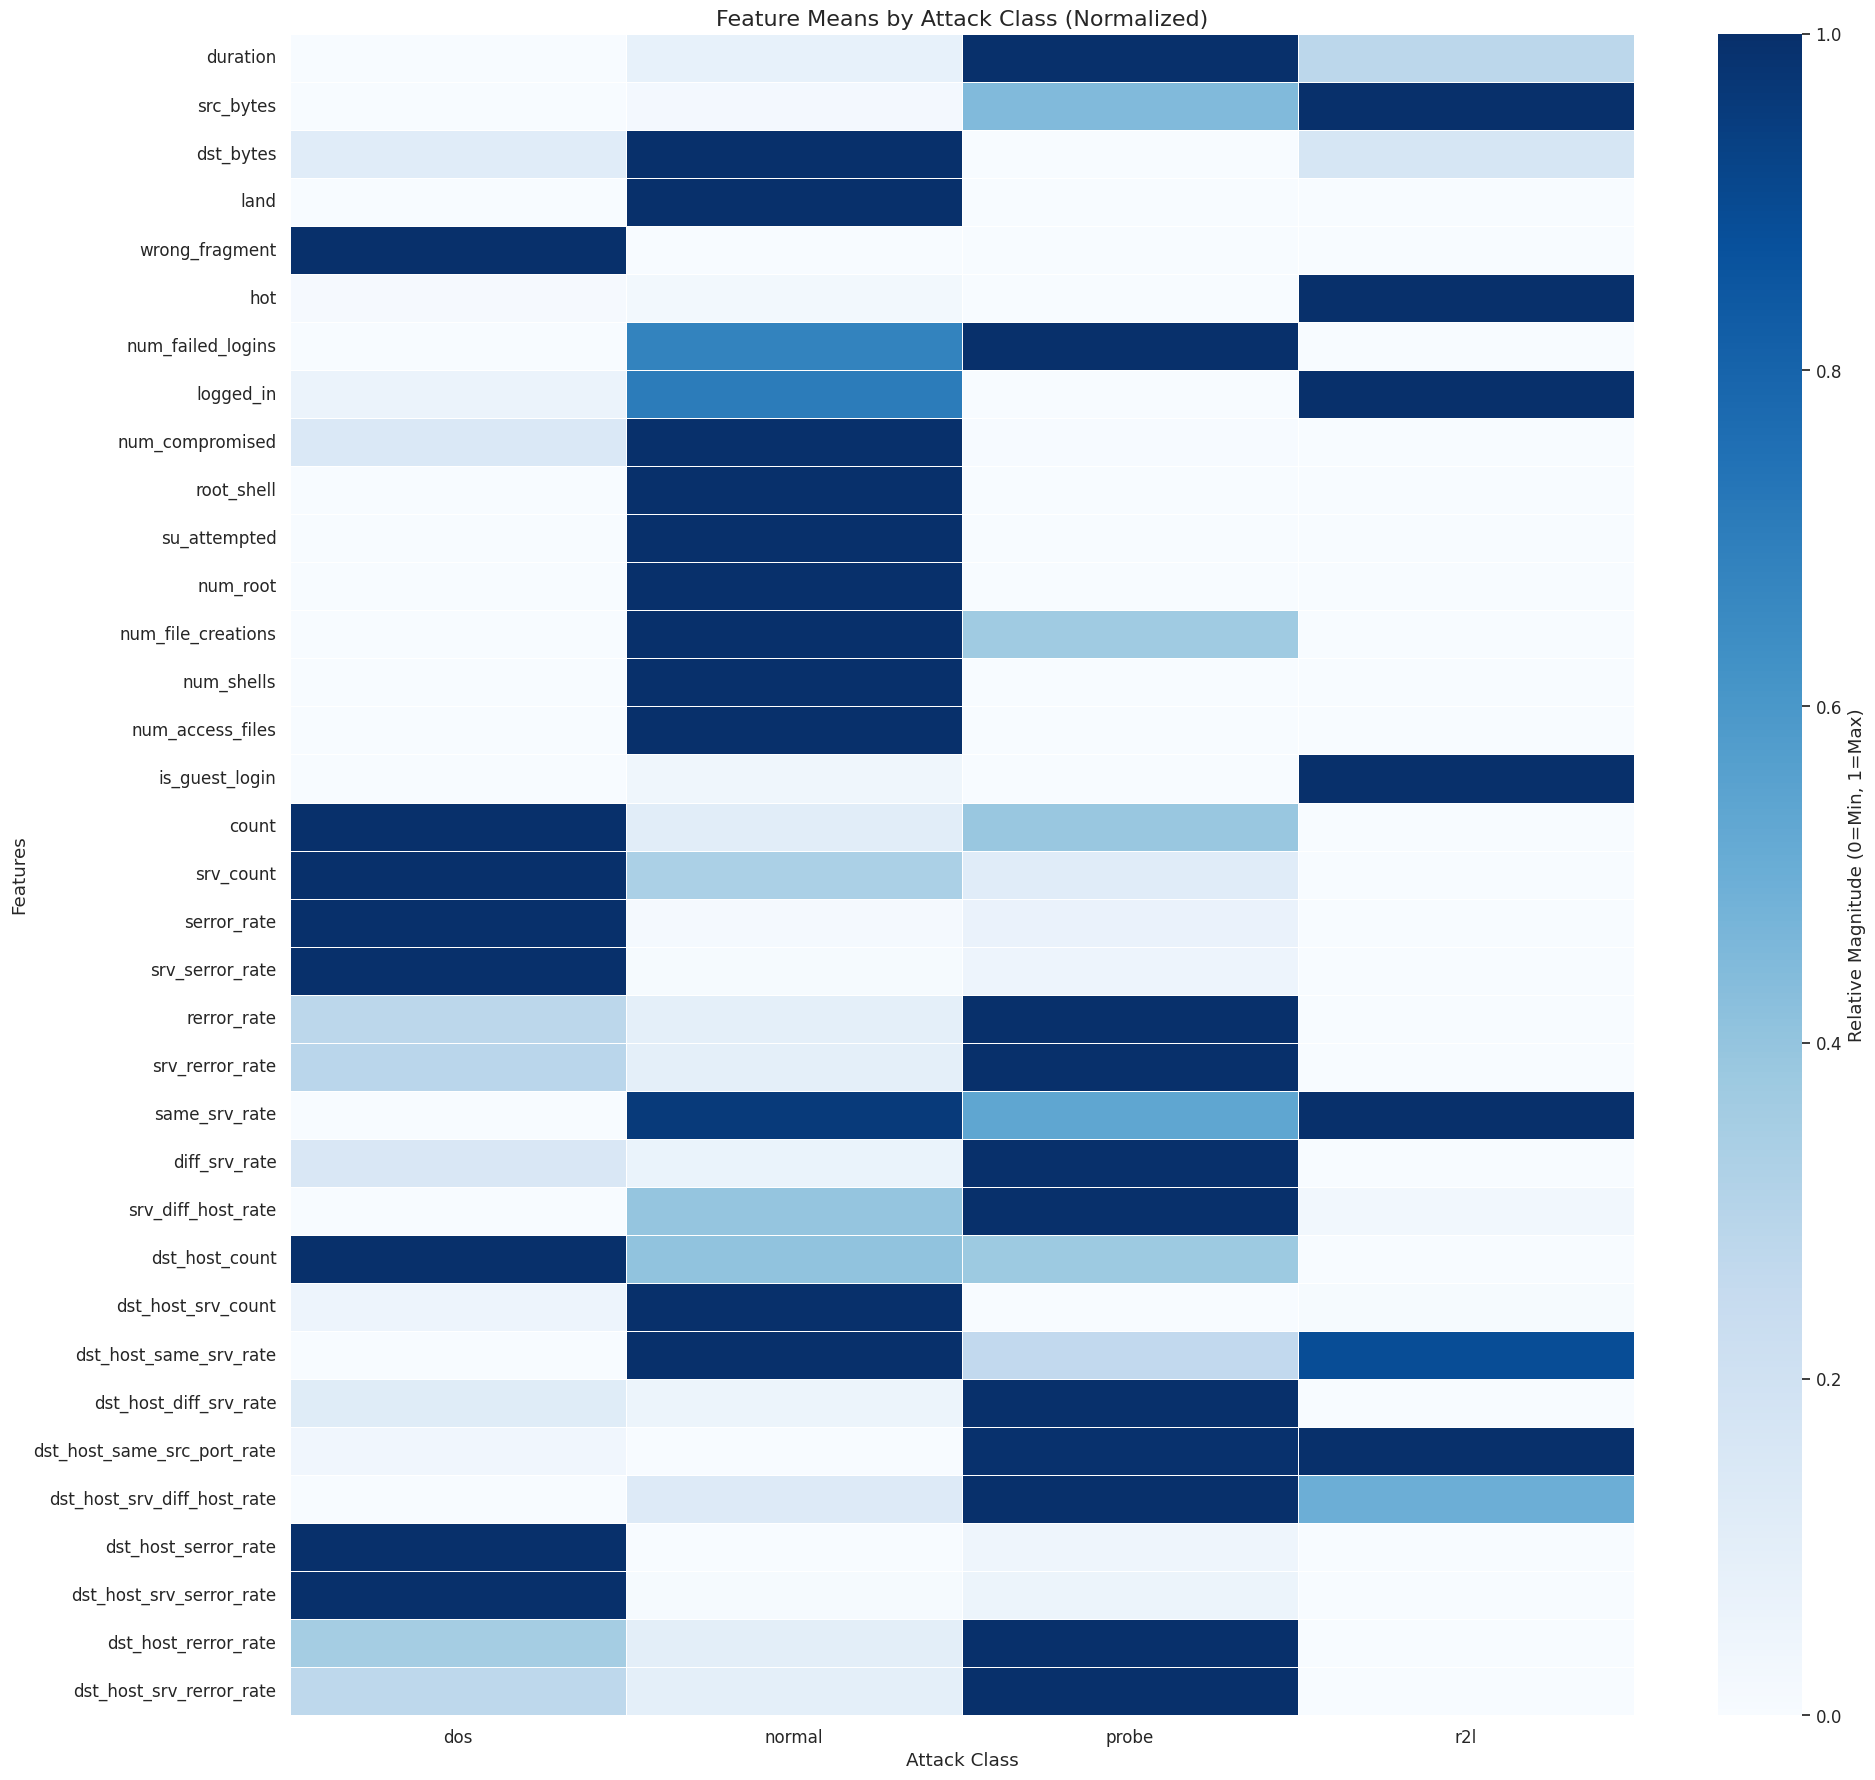

In [27]:
# --- Mean Heatmap ---
print("Generating Mean Heatmap...")
mean_stats = analysis_df.groupby('label').mean()
plot_feature_heatmap(mean_stats, "Feature Means by Attack Class (Normalized)", "task1_mean_heatmap")

Generating Std Dev Heatmap...


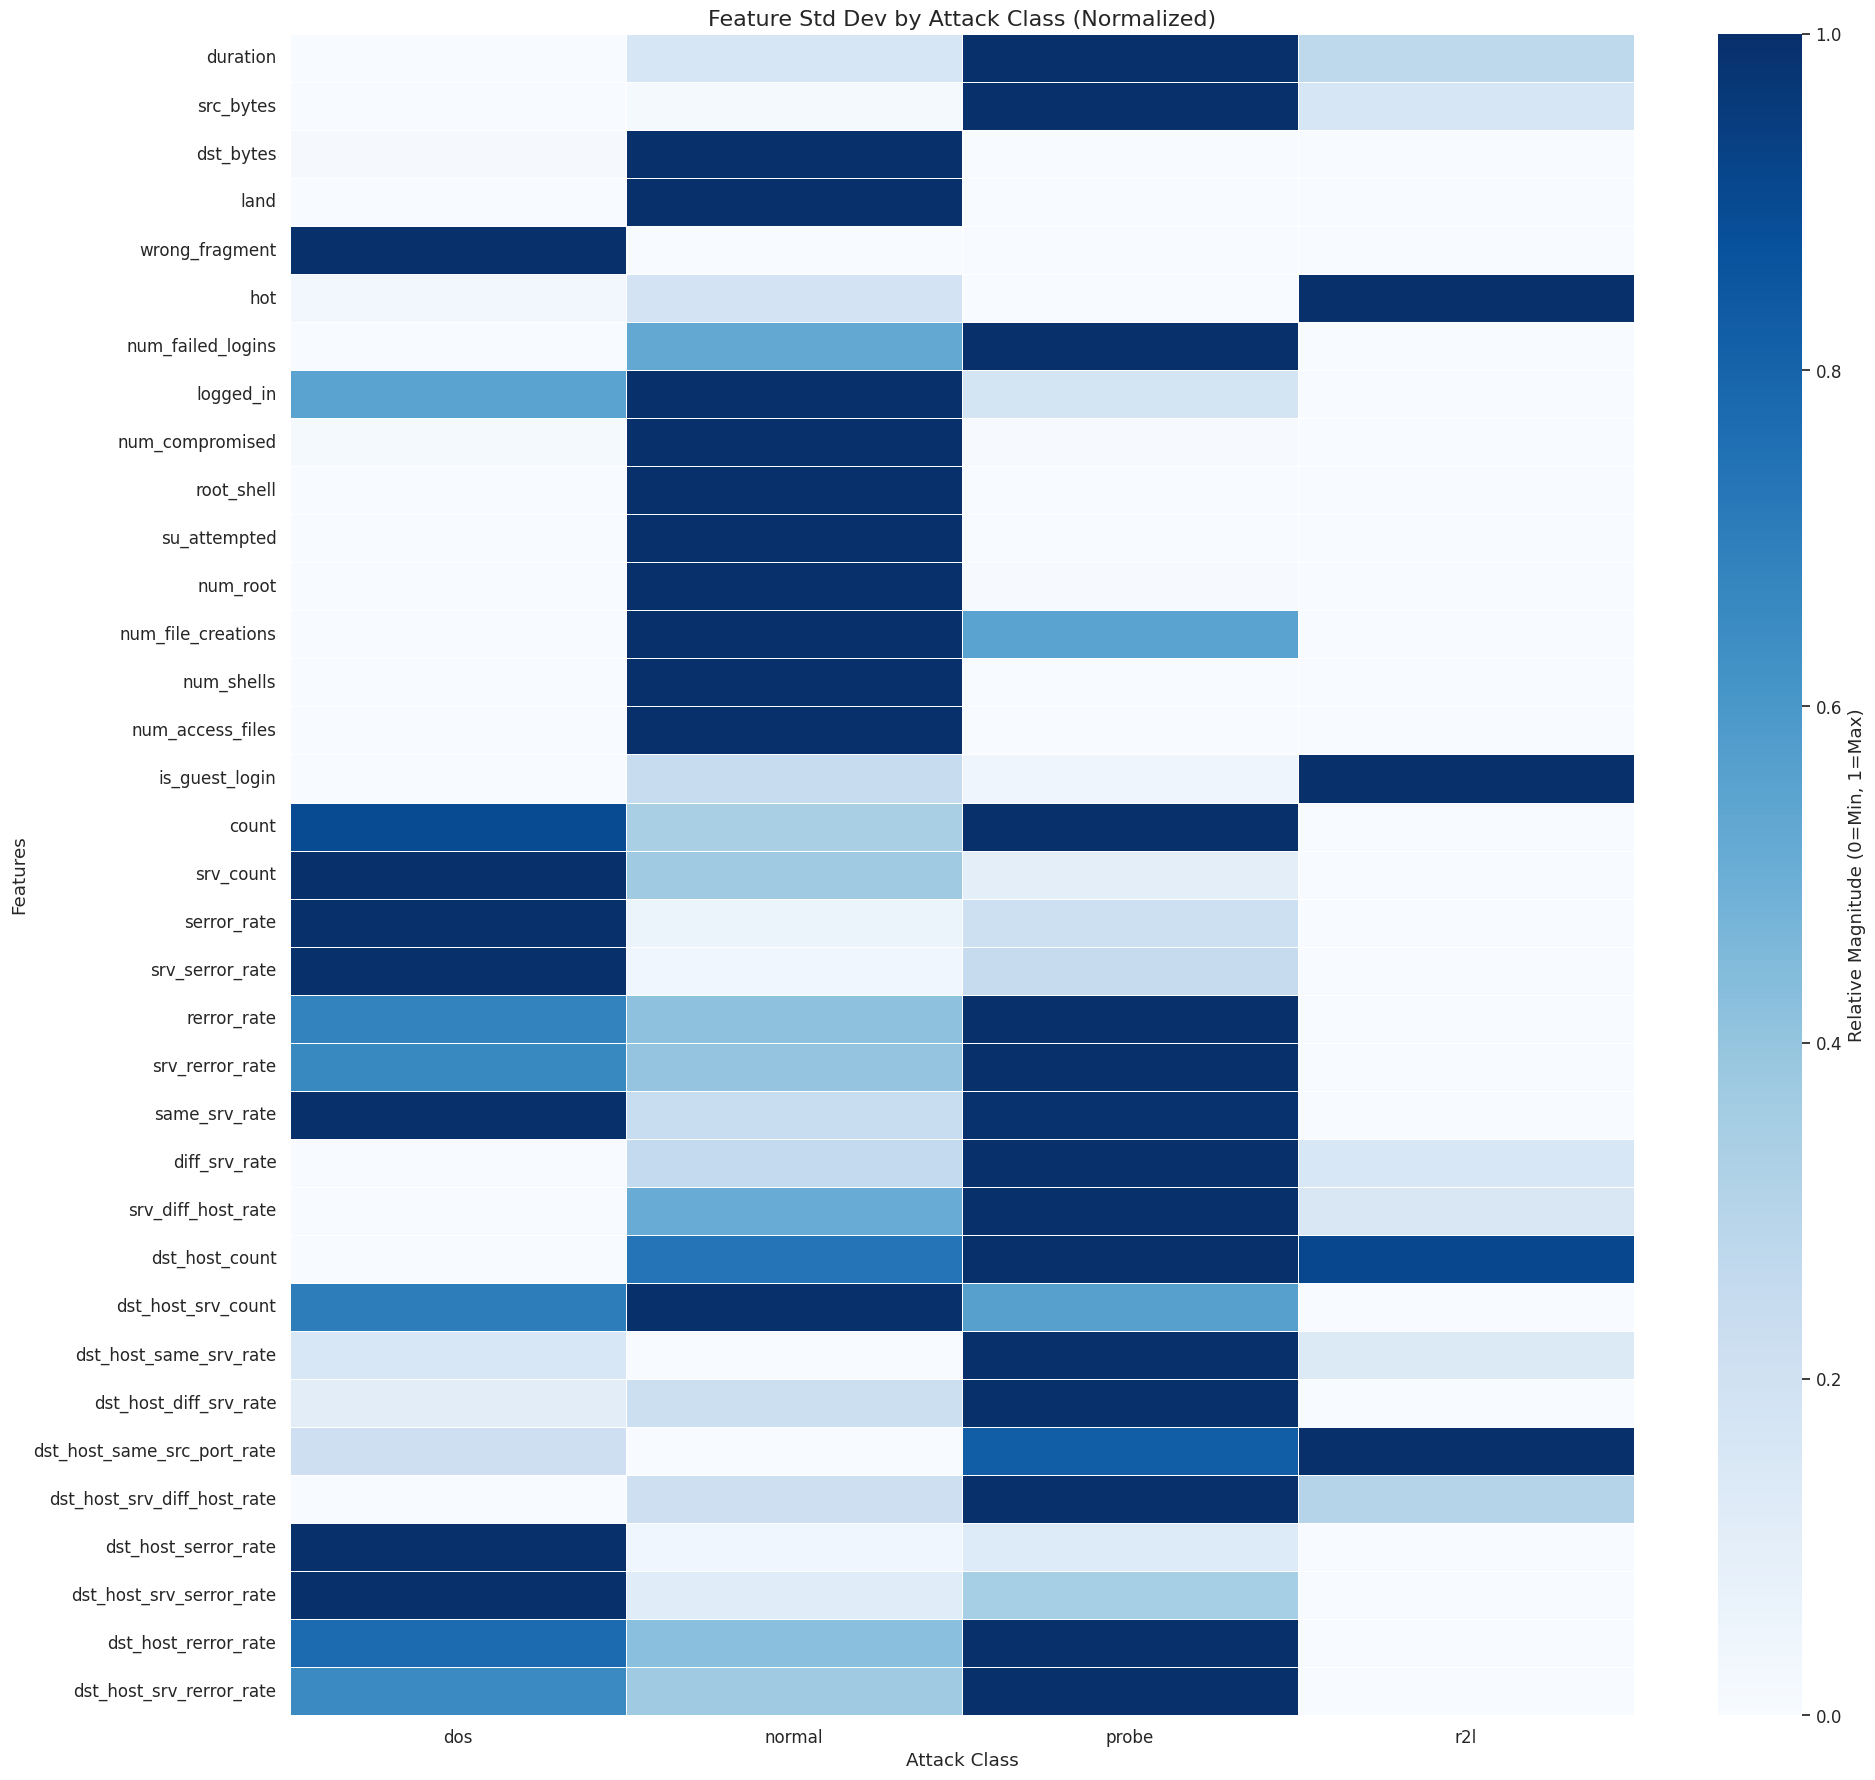

In [28]:
# --- Standard Deviation Heatmap ---
print("Generating Std Dev Heatmap...")
std_stats = analysis_df.groupby('label').std()
plot_feature_heatmap(std_stats, "Feature Std Dev by Attack Class (Normalized)", "task1_std_heatmap")

Generating Median Heatmap...


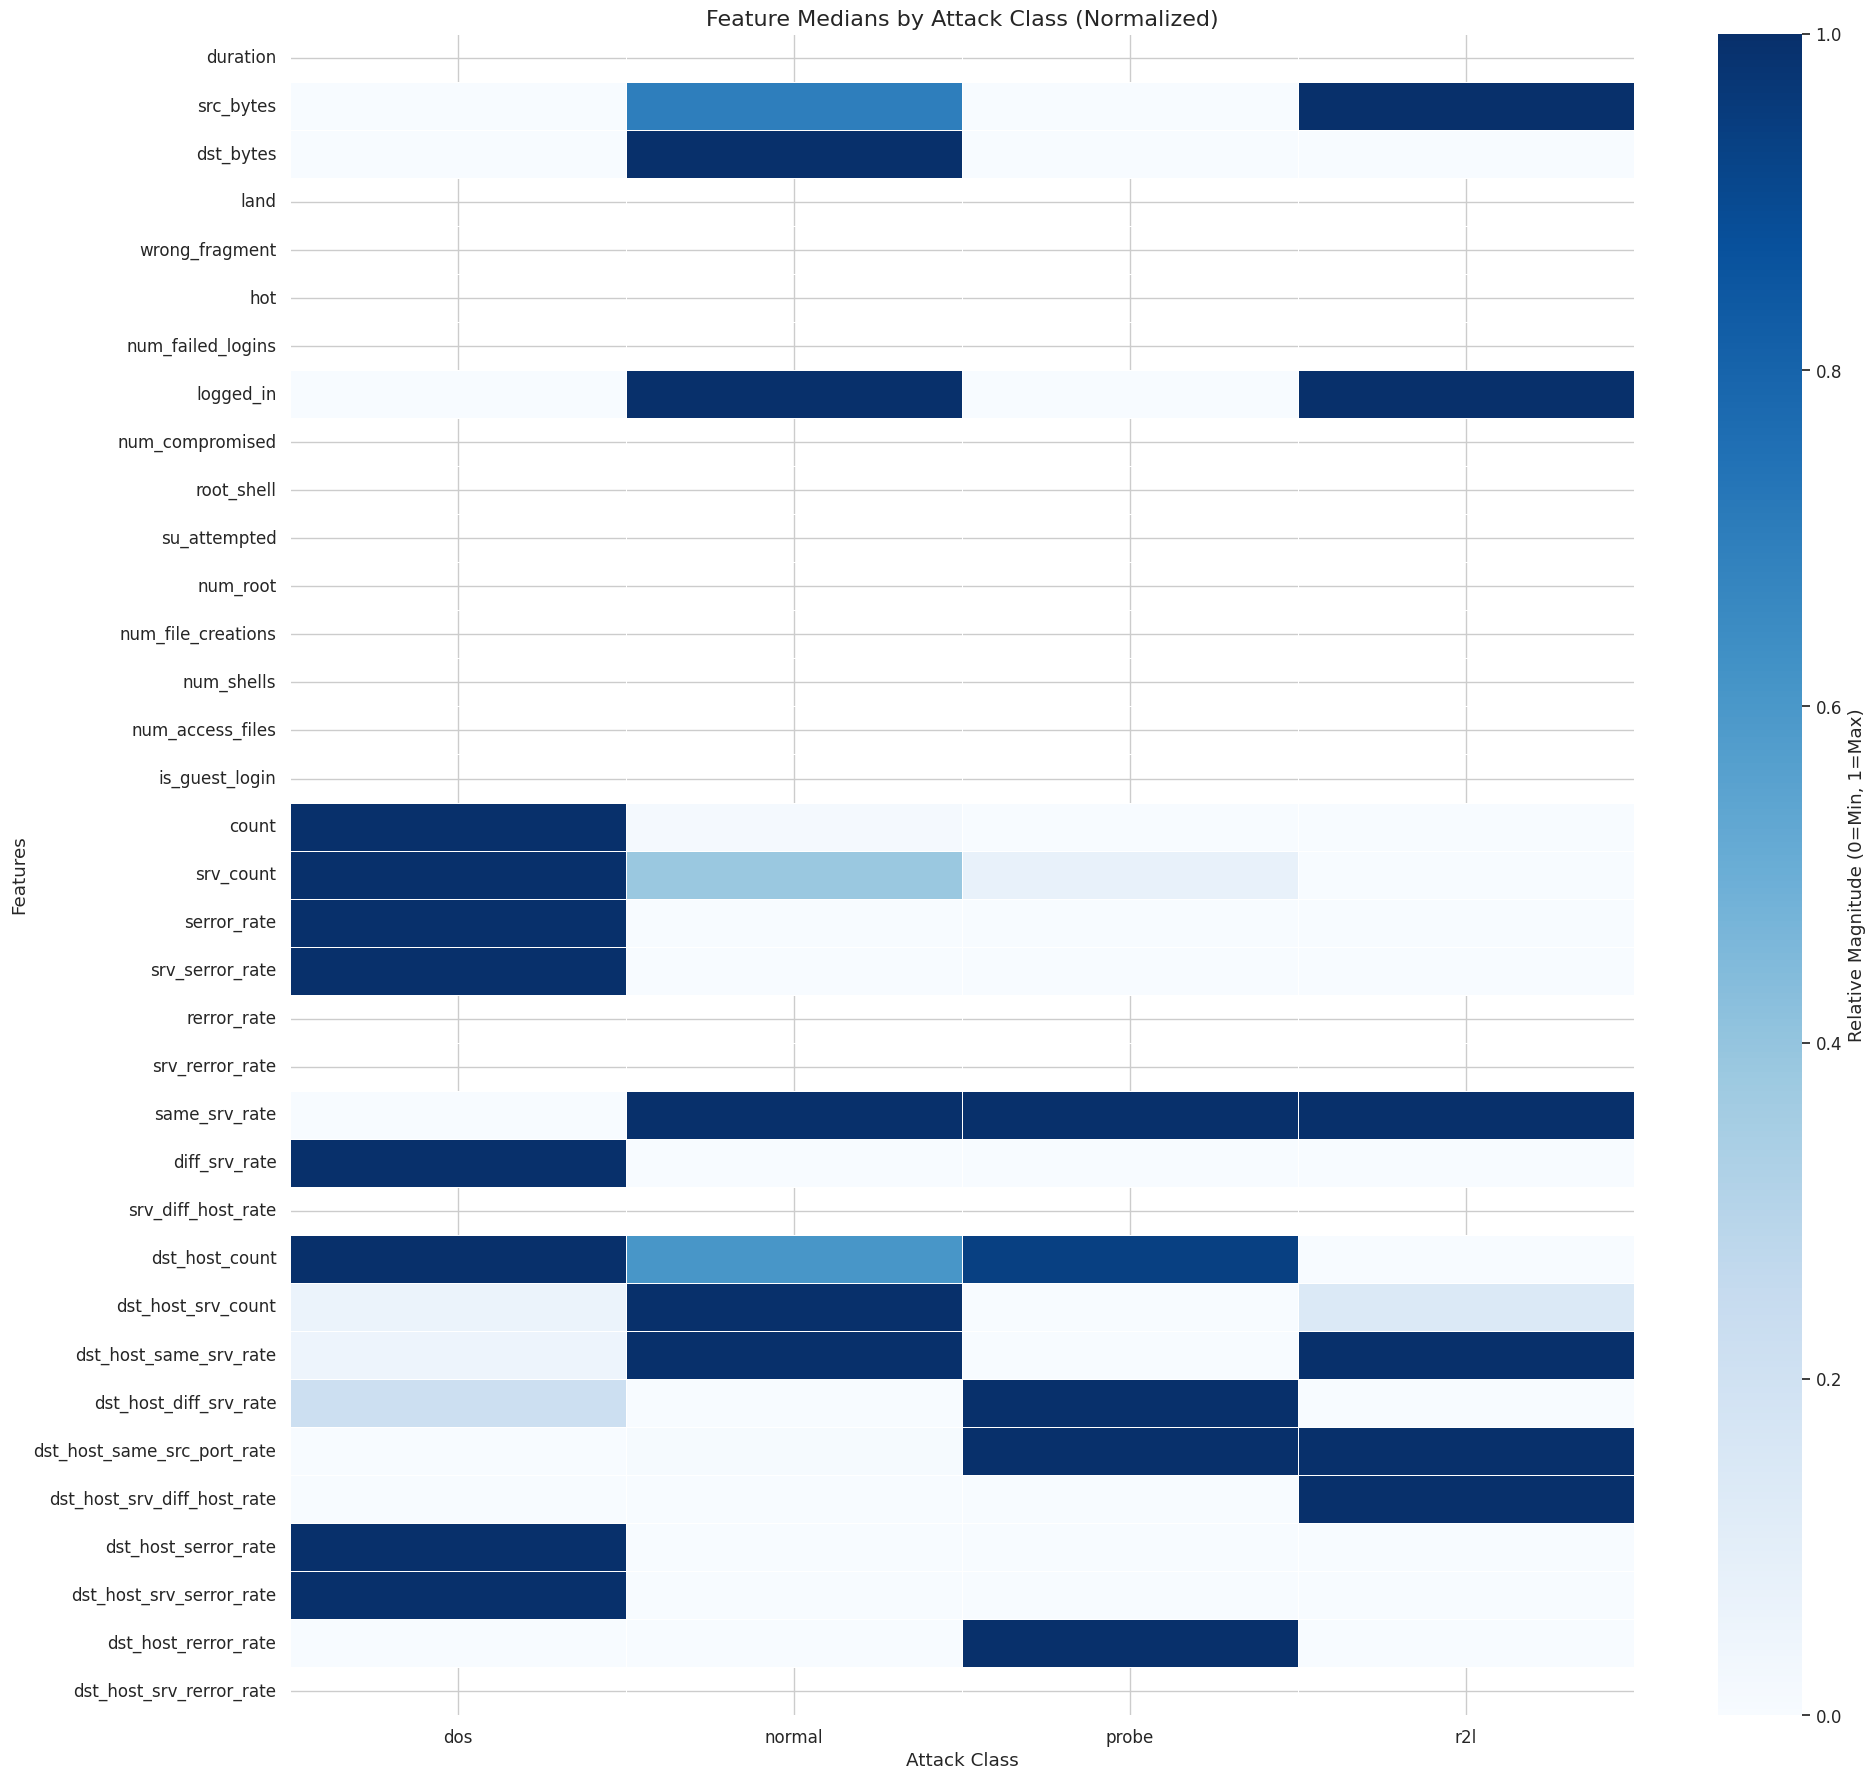

In [29]:
# --- Median Heatmap ---
print("Generating Median Heatmap...")
median_stats = analysis_df.groupby('label').median()
plot_feature_heatmap(median_stats, "Feature Medians by Attack Class (Normalized)", "task1_median_heatmap")

#### Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?

TODO

## Task 2 - Shallow Anomaly Detection - Supervised vs Unsupervised

text

In [30]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

### One-Class SVM with Normal data only

First, train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic only using an rbf kernel. Then, evaluate the performance using all training data (normal + anomalies).

Normal Training Samples: 9413

Training OC-SVM with nu=0.01 (Estimate)...
Training OC-SVM with nu=0.5 (Default)...

--- OC-SVM (Normal Only) | nu=0.01 ---
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.95      9413
     Anomaly       0.97      0.76      0.85      3768

    accuracy                           0.92     13181
   macro avg       0.94      0.88      0.90     13181
weighted avg       0.93      0.92      0.92     13181



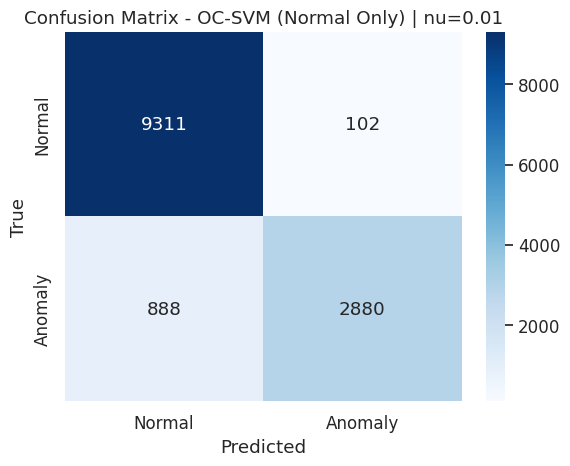


--- OC-SVM (Normal Only) | nu=0.5 ---
              precision    recall  f1-score   support

      Normal       0.99      0.50      0.66      9413
     Anomaly       0.44      0.99      0.61      3768

    accuracy                           0.64     13181
   macro avg       0.72      0.74      0.64     13181
weighted avg       0.83      0.64      0.65     13181



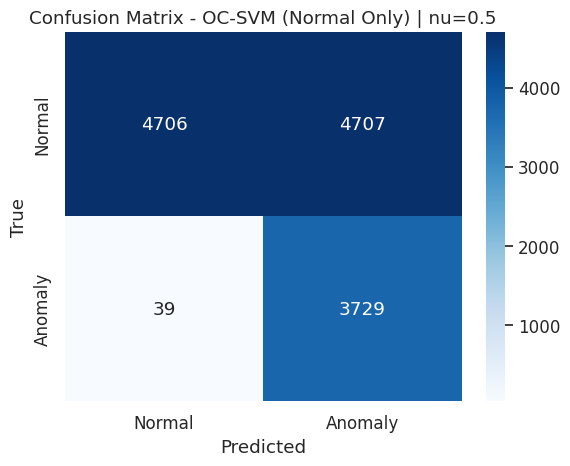

0.6379471362872974

In [31]:
# 1. Filter training data to get only Normal samples
# We use the boolean index from y_train_binary (0 = Normal)
X_train_normal = X_train[y_train_binary == 0]

print(f"Normal Training Samples: {X_train_normal.shape[0]}\n")

# 2. Define Estimates for Nu
# Estimate: Since data is 'clean' (normal only), we expect very few outliers.
# We set a low nu (e.g., 0.01) to allow for 1% noise but mostly fit the data tightly.
nu_estimate = 0.01
nu_default = 0.5 # Sklearn default

# 3. Define Models
ocsvm_est = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_def = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_default)

# 4. Train Models (Fit on Normal Only)
print(f"Training OC-SVM with nu={nu_estimate} (Estimate)...")
ocsvm_est.fit(X_train_normal)

print(f"Training OC-SVM with nu={nu_default} (Default)...")
ocsvm_def.fit(X_train_normal)

# 5. Evaluation Function
def evaluate_model(model, X, y_true, title):
    # Predict: 1 for inlier (normal), -1 for outlier (anomaly)
    y_pred_raw = model.predict(X)

    # Convert prediction to match our binary labels:
    # OC-SVM: 1 (normal), -1 (anomaly)
    # Our Labels: 0 (normal), 1 (anomaly)
    # Transformation: -1 -> 1, 1 -> 0
    y_pred = [1 if p == -1 else 0 for p in y_pred_raw]

    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
    plt.title('Confusion Matrix - %s'%(title))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

    return f1_score(y_true, y_pred, average='macro')

# 6. Evaluate on FULL Training Data (Normal + Anomalies)
evaluate_model(ocsvm_est, X_train, y_train_binary, f"OC-SVM (Normal Only) | nu={nu_estimate}")
evaluate_model(ocsvm_def, X_train, y_train_binary, f"OC-SVM (Normal Only) | nu={nu_default}")

#### Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on training performance? Try both your estimate and the default value of `nu`.

A good estimate for `nu` is a small value, such as **0.01**. Since the training data consists purely of normal traffic, we assume a low contamination rate (1% noise). The default value of `nu=0.5` is unsuitable because it forces the model to treat 50% of the valid normal data as outliers, resulting in a massive false positive rate (Normal Recall ~0.50).

### One-Class SVM with All data

Now train the OC-SVM with both normal and anomalous data. Estimate nu as the ratio of anomalous data across the entire collection. Then, evaluate the performance.

Total Samples: 13181, Anomalies: 3768

Estimated nu (Anomaly Ratio): 0.2859

Training OC-SVM with nu=0.2859 on ALL data...

--- OC-SVM (All Data) | nu=0.2859 ---
              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85      9413
     Anomaly       0.63      0.63      0.63      3768

    accuracy                           0.79     13181
   macro avg       0.74      0.74      0.74     13181
weighted avg       0.79      0.79      0.79     13181



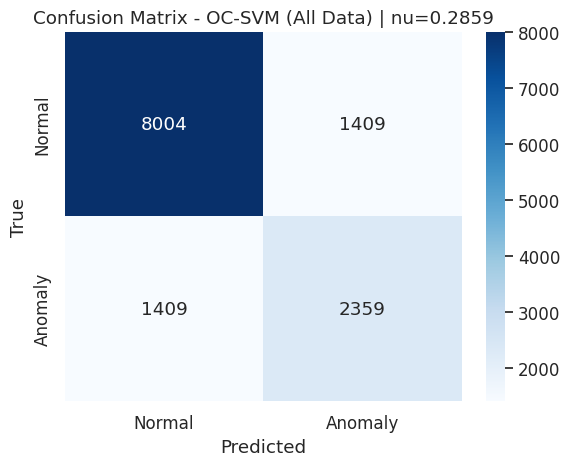

0.7381874837459961

In [32]:
# 1. Estimate Nu as the ratio of anomalies in the entire training set
# nu is essentially the "Upper bound on the fraction of training errors"
# and "Lower bound of the fraction of support vectors"
n_samples = len(y_train_binary)
n_anomalies = y_train_binary.sum() # Sum of 1s
nu_ratio = n_anomalies / n_samples

print(f"Total Samples: {n_samples}, Anomalies: {n_anomalies}\n")
print(f"Estimated nu (Anomaly Ratio): {nu_ratio:.4f}\n")

# 2. Train Model on FULL Training Data
# We must slightly cap nu because if nu=1.0 the model fails.
# Usually nu should be in (0, 1].
ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=min(nu_ratio, 0.99))

print(f"Training OC-SVM with nu={nu_ratio:.4f} on ALL data...")
ocsvm_all.fit(X_train)

# 3. Evaluate on Full Training Data
evaluate_model(ocsvm_all, X_train, y_train_binary, f"OC-SVM (All Data) | nu={nu_ratio:.4f}")

#### Q: Which model performs better? Why do you think that?

The **Normal Only** model performs significantly better (Macro-F1 **0.90** vs **0.74**). This is because One-Class SVM relies on defining a tight boundary around 'normal' behavior. When trained on clean data, this boundary is precise. When trained on 'All Data', the presence of anomalies (even when `nu` is adjusted) distorts the decision boundary in the kernel space, making it less effective at distinguishing marginal anomalies.

### One-Class SVM with normal traffic and some anomalies

Evaluate the impact of the percentage of anomalies while training. Train several OC-SVMs with an increasing subsample of anomalous classes (10%, 20%, 50%, 100% of anomalies). Estimate the nu parameter for each scenario.

Evaluating impact of anomaly contamination...

--- Contamination: 0% (nu=0.010) ---
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.95      9413
     Anomaly       0.97      0.76      0.85      3768

    accuracy                           0.92     13181
   macro avg       0.94      0.88      0.90     13181
weighted avg       0.93      0.92      0.92     13181



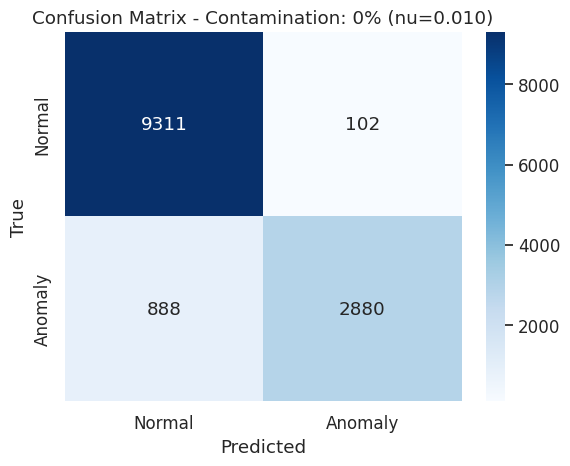


--- Contamination: 10% (nu=0.038) ---
              precision    recall  f1-score   support

      Normal       0.77      0.97      0.86      9413
     Anomaly       0.79      0.28      0.41      3768

    accuracy                           0.77     13181
   macro avg       0.78      0.62      0.63     13181
weighted avg       0.78      0.77      0.73     13181



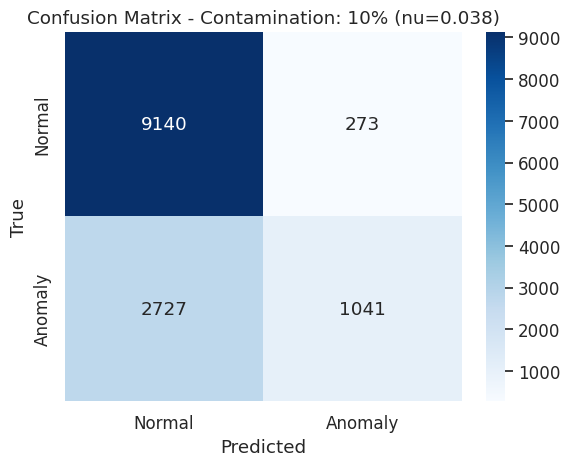


--- Contamination: 20% (nu=0.074) ---
              precision    recall  f1-score   support

      Normal       0.79      0.95      0.86      9413
     Anomaly       0.75      0.37      0.50      3768

    accuracy                           0.79     13181
   macro avg       0.77      0.66      0.68     13181
weighted avg       0.78      0.79      0.76     13181



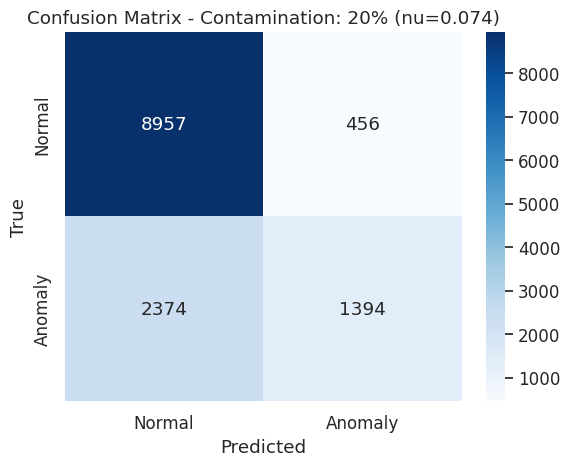


--- Contamination: 50% (nu=0.167) ---
              precision    recall  f1-score   support

      Normal       0.82      0.90      0.86      9413
     Anomaly       0.68      0.51      0.58      3768

    accuracy                           0.79     13181
   macro avg       0.75      0.71      0.72     13181
weighted avg       0.78      0.79      0.78     13181



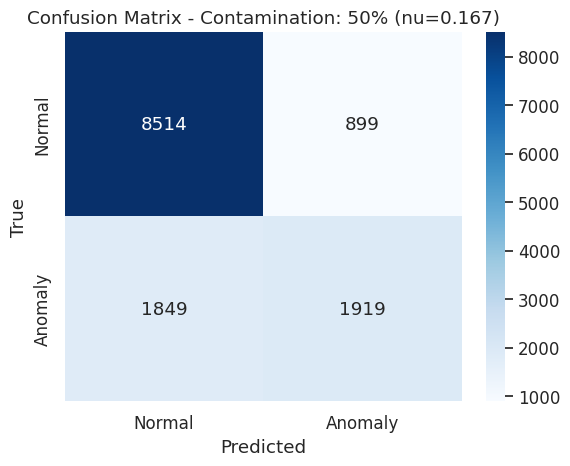


--- Contamination: 100% (nu=0.286) ---
              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85      9413
     Anomaly       0.63      0.63      0.63      3768

    accuracy                           0.79     13181
   macro avg       0.74      0.74      0.74     13181
weighted avg       0.79      0.79      0.79     13181



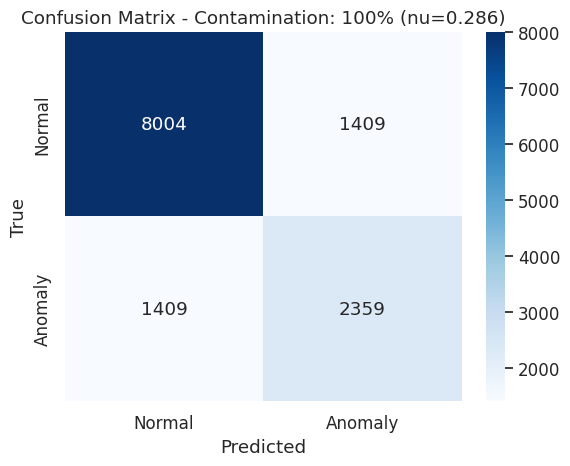

In [33]:
percentages = [0.0, 0.1, 0.2, 0.5, 1.0]
f1_scores = []
models_dict = {} # To store models for the robustness check later

# Separate data indices
idx_normal = y_train_binary[y_train_binary == 0].index
idx_anomaly = y_train_binary[y_train_binary == 1].index

print("Evaluating impact of anomaly contamination...")

for p in percentages:
    # 1. Subsample Anomalies
    # If p=0, take 0 anomalies. If p=1, take all anomalies.
    if p == 0:
        sampled_anomaly_idx = []
    else:
        # Sample p * 100% of the anomaly indices
        n_subs = int(len(idx_anomaly) * p)
        sampled_anomaly_idx = idx_anomaly[:n_subs] # Deterministic slicing for reproducibility

    # 2. Create Combined Training Subset
    # (All Normal + Subsampled Anomalies)
    current_idx = idx_normal.tolist() + list(sampled_anomaly_idx)
    X_sub = X_train.loc[current_idx]
    y_sub = y_train_binary.loc[current_idx]

    # 3. Estimate Nu for this specific subset
    # nu = count(anomalies in subset) / count(total subset)
    # If p=0, nu would be 0.0, which is invalid for OC-SVM.
    # We use a small epsilon (0.01) for the 0% case.
    if len(sampled_anomaly_idx) == 0:
        nu_curr = 0.01
    else:
        nu_curr = len(sampled_anomaly_idx) / len(current_idx)
        # Cap nu to avoid instability
        nu_curr = min(nu_curr, 0.99)

    # 4. Train
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_curr)
    model.fit(X_sub)

    # Store for Task 2.4
    if p == 0.1:
        models_dict['10%_anomalies'] = model
    if p == 0.0:
         models_dict['0%_anomalies'] = model

    # 5. Evaluate on FULL Training Set (Standard benchmark)
    f1 = evaluate_model(model, X_train, y_train_binary, f"Contamination: {int(p*100)}% (nu={nu_curr:.3f})")
    f1_scores.append(f1)

Saved plot: ./plots/task2_contamination_impact.png


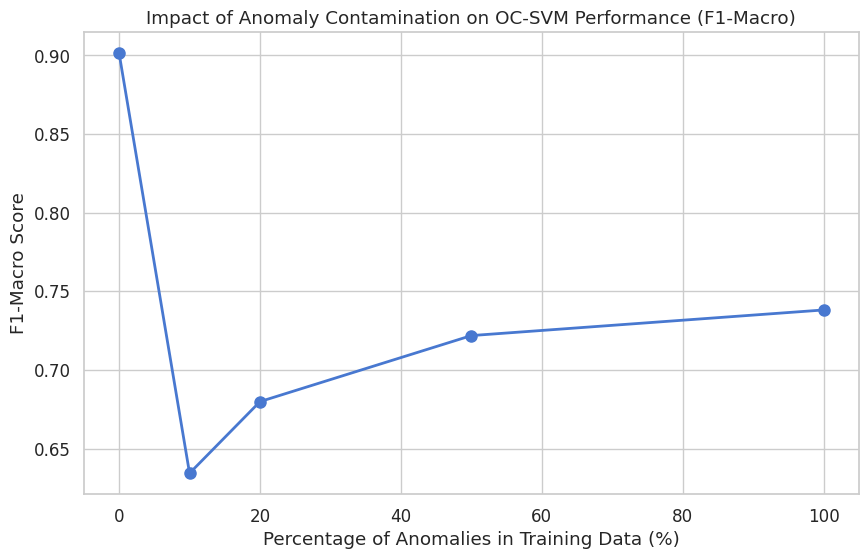

In [34]:
# --- Plotting the Results ---
plt.figure(figsize=(10, 6))
plt.plot([p*100 for p in percentages], f1_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title("Impact of Anomaly Contamination on OC-SVM Performance (F1-Macro)")
plt.xlabel("Percentage of Anomalies in Training Data (%)")
plt.ylabel("F1-Macro Score")
plt.grid(True)
save_plot(plt.gcf(), "task2_contamination_impact")
plt.show()

#### Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?

The results show a characteristic 'U-shaped' (or check-mark) trend. Performance is highest with **0% contamination** (F1 0.90). Introducing a small amount of anomalies (10-20%) causes a sharp performance drop (F1 ~0.63) because the `nu` parameter (estimated from the subset) is too low to reject the full set of anomalies during evaluation. As contamination increases towards 100% and `nu` is adjusted to match the true anomaly ratio (0.28), performance recovers (F1 0.74) but never reaches the peak achieved with clean data.

### Robustness of the One-Class SVM model

Finally, use the test set to assess the robustness. [cite: 106] Use models trained with:
1. Only normal data
2. All data
3. 10% of anomalous data

Robustness Check on Test Set

==================== Normal Only (nu=0.01) ====================
              precision    recall  f1-score   support

      Normal       0.64      0.75      0.69      2152
     Anomaly       0.83      0.75      0.79      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.75      0.74      5826
weighted avg       0.76      0.75      0.75      5826



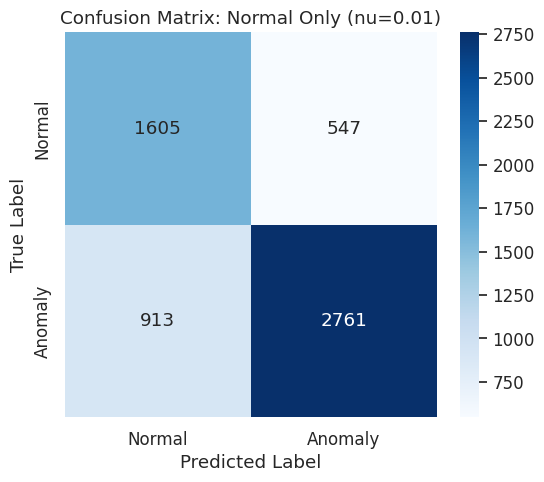


Most Confused Attacks (False Negatives) for Normal Only (nu=0.01):
dos      785
probe    128
Name: count, dtype: int64

==================== All Data (nu=ratio) ====================
              precision    recall  f1-score   support

      Normal       0.56      0.60      0.58      2152
     Anomaly       0.76      0.73      0.74      3674

    accuracy                           0.68      5826
   macro avg       0.66      0.66      0.66      5826
weighted avg       0.69      0.68      0.68      5826



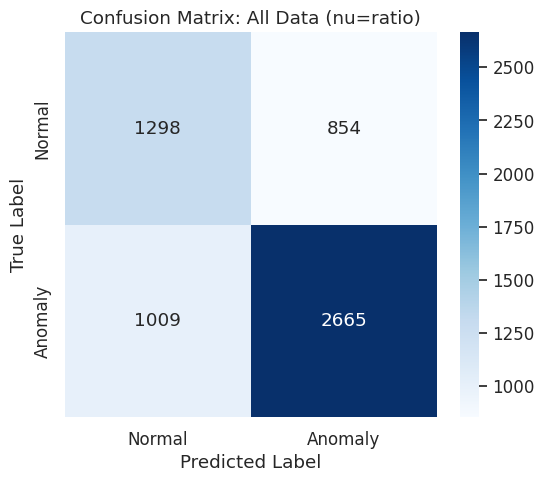


Most Confused Attacks (False Negatives) for All Data (nu=ratio):
dos      990
probe     19
Name: count, dtype: int64

==================== 10% Anomalies ====================
              precision    recall  f1-score   support

      Normal       0.41      0.75      0.53      2152
     Anomaly       0.71      0.36      0.47      3674

    accuracy                           0.50      5826
   macro avg       0.56      0.55      0.50      5826
weighted avg       0.60      0.50      0.49      5826



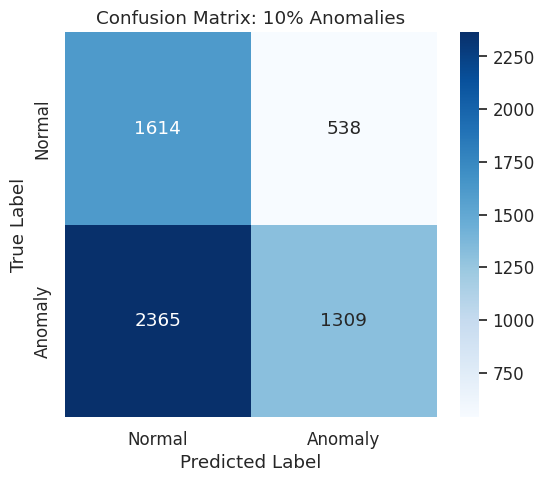


Most Confused Attacks (False Negatives) for 10% Anomalies:
dos      2032
probe     333
Name: count, dtype: int64


In [35]:
print("Robustness Check on Test Set")

# We compare 3 models:
# 1. Trained on Normal Only (Task 2.1, Best Estimate) -> ocsvm_est
# 2. Trained on All Data (Task 2.2) -> ocsvm_all
# 3. Trained on 10% Anomalies (Task 2.3) -> models_dict['10%_anomalies']

models_to_test = [
    ("Normal Only (nu=0.01)", ocsvm_est),
    ("All Data (nu=ratio)", ocsvm_all),
    ("10% Anomalies", models_dict['10%_anomalies'])
]

for name, model in models_to_test:
    print(f"\n{'='*20} {name} {'='*20}")

    # Get predictions
    y_pred_raw = model.predict(X_test)
    y_pred = [1 if p == -1 else 0 for p in y_pred_raw]

    # Classification Report
    print(classification_report(y_test_binary, y_pred, target_names=['Normal', 'Anomaly']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_binary, y_pred)

    # Plot CM
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Analyze Specific Attack Confusion (Advanced)
    # We look at which attack types were misclassified as Normal
    if hasattr(y_test_attack, 'values'):
        test_attacks = y_test_attack.values
    else:
        test_attacks = y_test_attack

    # Indices where True=Anomaly but Pred=Normal (False Negatives)
    fn_indices = (y_test_binary == 1) & (np.array(y_pred) == 0)

    if fn_indices.sum() > 0:
        missed_attacks = test_attacks[fn_indices]
        print(f"\nMost Confused Attacks (False Negatives) for {name}:")
        print(pd.Series(missed_attacks).value_counts().head(3))
    else:
        print("No anomalies missed!")

#### Q: Is the best-performing model in the training set also the best here? Does it confuse normal data with anomalies? Which attack is the most confused?

TODO

## Task 3 - Deep Anomaly Detection and Data Representation

text

In [36]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training and Validating Autoencoder with Normal data only

Create an Autoencoder with a shrinking encoder and an expansion decoder. Use normal data only; split into training and validation sets.

In [38]:
# --- Task 3.1: Autoencoder Architecture & Setup ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Prepare Data for PyTorch
# We need to convert Pandas DataFrames to PyTorch FloatTensors
# Note: We train ONLY on Normal data, but we validate on the Validation set (which has mixed data)
# to see if the loss divergence helps us.

# Filter X_train for normal data only
X_train_normal = X_train[y_train_binary == 0].values
X_val_np = X_val.values

# Convert to Tensors, ensuring float type
tensor_train_normal = torch.FloatTensor(X_train_normal.astype(float))
tensor_val = torch.FloatTensor(X_val_np.astype(float))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(tensor_train_normal, tensor_train_normal), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(tensor_val, tensor_val), batch_size=batch_size, shuffle=False)

# 2. Define Autoencoder Class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()

        # Encoder (Shrinking)
        # 114 -> 64 -> 32 (Bottleneck)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32), # Bottleneck
            nn.Tanh()
        )

        # Decoder (Expansion)
        # 32 -> 64 -> 114
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, input_dim)
            # No activation at the end because inputs are StandardScaler (unbounded), not 0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Model
input_dim = X_train.shape[1] # 114
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim).to(device)

print(f"Model Architecture:\n{model}")
print(f"Training on device: {device}")

Model Architecture:
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=114, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=114, bias=True)
  )
)
Training on device: cpu


Starting Training...
Epoch [10/50], Train Loss: 0.0548, Val Loss: 0.1182
Epoch [20/50], Train Loss: 0.0325, Val Loss: 0.1060
Epoch [30/50], Train Loss: 0.0237, Val Loss: 0.1107
Epoch [40/50], Train Loss: 0.0167, Val Loss: 0.1125
Epoch [50/50], Train Loss: 0.0139, Val Loss: 0.1160


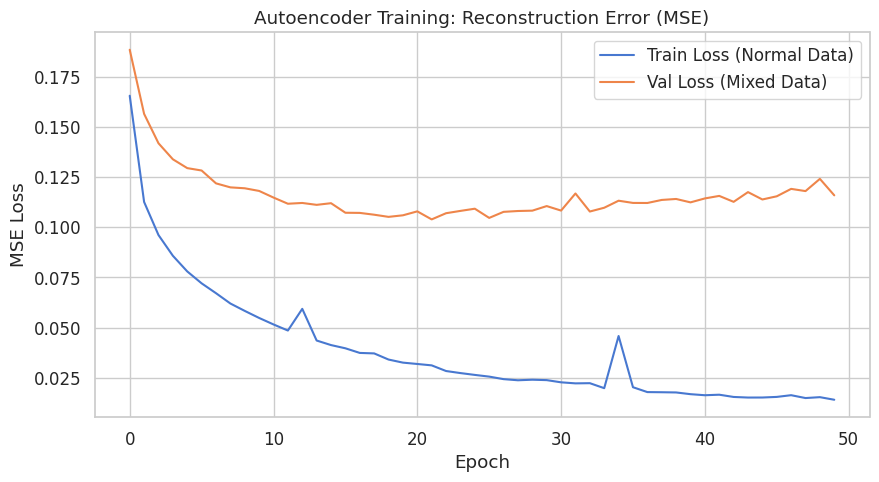

In [39]:
# --- Task 3.1 (Continued): Training Loop ---

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data # Autoencoder: Input = Target
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase (Calculate MSE on Validation set)
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (Normal Data)')
plt.plot(val_losses, label='Val Loss (Mixed Data)')
plt.title("Autoencoder Training: Reconstruction Error (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

### Estimate the Reconstruction Error Threshold

Estimate a threshold using the reconstruction error on the validation set. Plot the ECDF curve.

Estimated Reconstruction Threshold (95th percentile): 0.1940


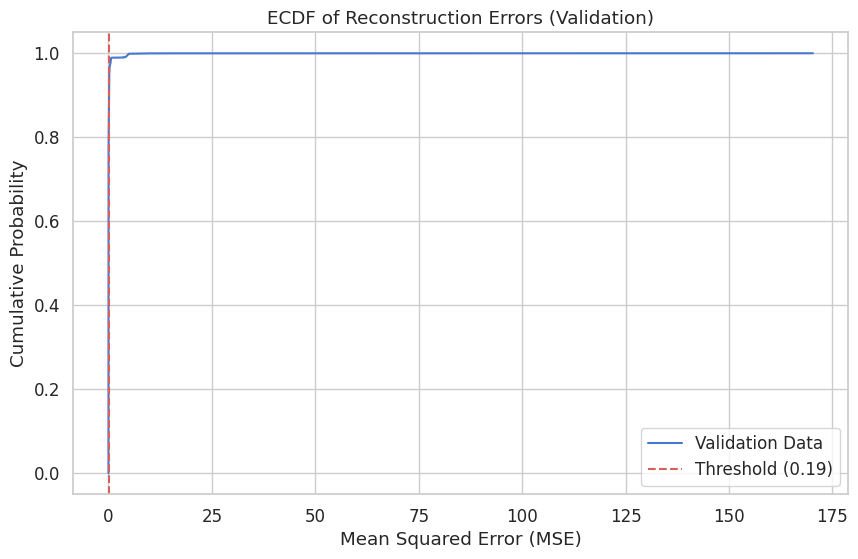

In [40]:
# --- Task 3.2: Estimate Reconstruction Threshold ---

# Helper to get reconstruction errors for a whole dataset
def get_reconstruction_errors(model, data_tensor):
    model.eval()
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        reconstructions = model(data_tensor)
        # MSE per sample: Mean over the feature dimension (axis 1)
        mse_per_sample = torch.mean((data_tensor - reconstructions) ** 2, dim=1)
    return mse_per_sample.cpu().numpy()

# 1. Get errors for Validation Set
# Note: We split Val set into Normal and Anomaly just for visualization analysis
val_errors = get_reconstruction_errors(model, tensor_val)

# 2. Define Threshold using Percentile on Validation Data
# Since Val contains anomalies, we shouldn't use Max().
# We assume 90-95% of validation data is normal, so we take the 95th percentile.
threshold = np.percentile(val_errors, 95)

print(f"Estimated Reconstruction Threshold (95th percentile): {threshold:.4f}")

# 3. Plot ECDF (Empirical Cumulative Distribution Function)
def plot_ecdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, label=label)

plt.figure(figsize=(10, 6))
plot_ecdf(val_errors, "Validation Data")
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title("ECDF of Reconstruction Errors (Validation)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()

#### Q: How did you pick the threshold? What is its value?

TODO

### Anomaly Detection with reconstruction error

Use the trained model and threshold to classify anomalies in the full training set and test set.

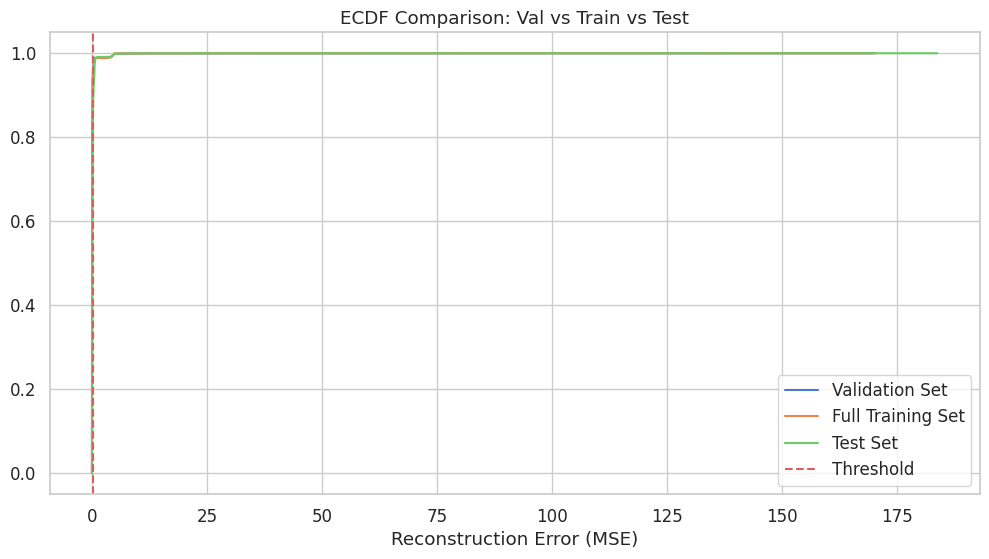


--- Autoencoder Classification Results (Test Set) ---
              precision    recall  f1-score   support

      Normal       0.43      0.96      0.59      2152
     Anomaly       0.92      0.25      0.39      3674

    accuracy                           0.51      5826
   macro avg       0.68      0.61      0.49      5826
weighted avg       0.74      0.51      0.46      5826



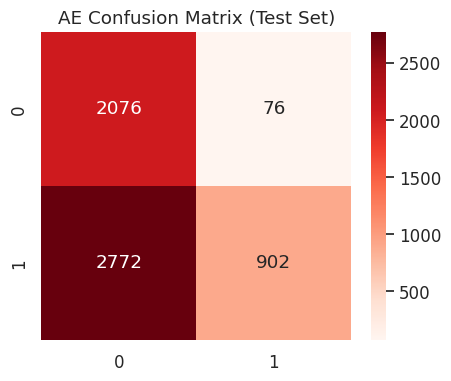

In [42]:
# --- Task 3.3: Anomaly Detection Evaluation ---

# 1. Compute Errors for Full Train and Test
tensor_train_full = torch.FloatTensor(X_train.values.astype(float))
tensor_test = torch.FloatTensor(X_test.values.astype(float))

train_errors = get_reconstruction_errors(model, tensor_train_full)
test_errors = get_reconstruction_errors(model, tensor_test)

# 2. Plot ECDFs for all sets
plt.figure(figsize=(12, 6))
plot_ecdf(val_errors, "Validation Set")
plot_ecdf(train_errors, "Full Training Set")
plot_ecdf(test_errors, "Test Set")
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("ECDF Comparison: Val vs Train vs Test")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()

# 3. Classification & Evaluation
# If Error > Threshold -> Anomaly (1)
# If Error <= Threshold -> Normal (0)

y_pred_train = (train_errors > threshold).astype(int)
y_pred_test = (test_errors > threshold).astype(int)

print("\n--- Autoencoder Classification Results (Test Set) ---")
print(classification_report(y_test_binary, y_pred_test, target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("AE Confusion Matrix (Test Set)")
plt.show()

#### Q: Plot and report the ECDF... Why the reconstruction errors higher on the full training set than on the validation one? And why are the reconstruction errors in the test set even higher? How is the performance on the training... and test set?

TODO

### Auto-Encoder's bottleneck and OC-SVM

Use the encoder's bottleneck for data representation. Train an OC-SVM on the bottleneck embeddings of the normal data.

Bottleneck Shape: (9413, 32)
Training OC-SVM on Autoencoder Embeddings...

--- OC-SVM on Latent Space (AE) ---
              precision    recall  f1-score   support

      Normal       0.60      0.77      0.67      2152
     Anomaly       0.84      0.69      0.76      3674

    accuracy                           0.72      5826
   macro avg       0.72      0.73      0.72      5826
weighted avg       0.75      0.72      0.73      5826



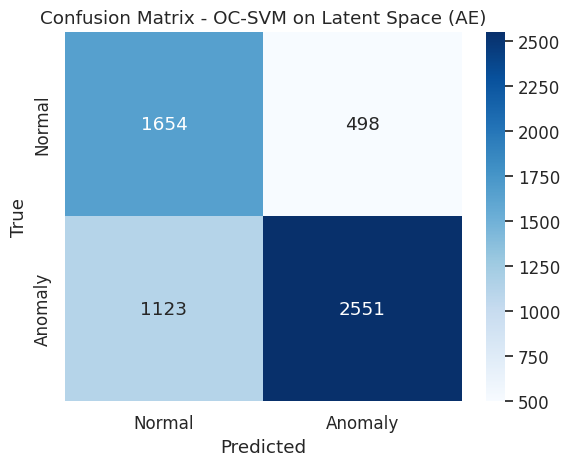

0.7150087240601458

In [43]:
# --- Task 3.4: Bottleneck Embeddings + OC-SVM ---

# 1. Extract Embeddings (Bottleneck)
def get_embeddings(model, data_tensor):
    model.eval()
    with torch.no_grad():
        # We only run the ENCODER part
        embeddings = model.encoder(data_tensor.to(device))
    return embeddings.cpu().numpy()

# Get embeddings for Normal Train Data (to train OC-SVM)
# and Full Test Data (to evaluate)
embeddings_train_normal = get_embeddings(model, tensor_train_normal) # Defined in Block 1
embeddings_test = get_embeddings(model, tensor_test)

print(f"Bottleneck Shape: {embeddings_train_normal.shape}") # Should be (N, 32)

# 2. Train OC-SVM on Embeddings
# We use the best 'nu' found in Task 2.1 (e.g., 0.01)
ocsvm_latent = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
print("Training OC-SVM on Autoencoder Embeddings...")
ocsvm_latent.fit(embeddings_train_normal)

# 3. Predict on Test Embeddings
# OC-SVM predicts -1 for anomaly, 1 for normal
y_pred_latent_raw = ocsvm_latent.predict(embeddings_test)
y_pred_latent = [1 if p == -1 else 0 for p in y_pred_latent_raw]

# 4. Evaluate
evaluate_model(ocsvm_latent, embeddings_test, y_test_binary, "OC-SVM on Latent Space (AE)")

#### Q: Compare the results with the best original OC-SVM and with the Autoencoder with reconstruction error. Describe the performance...

TODO

### PCA and OC-SVM

Use PCA for data representation. Analyze the explained variance on normal data only.

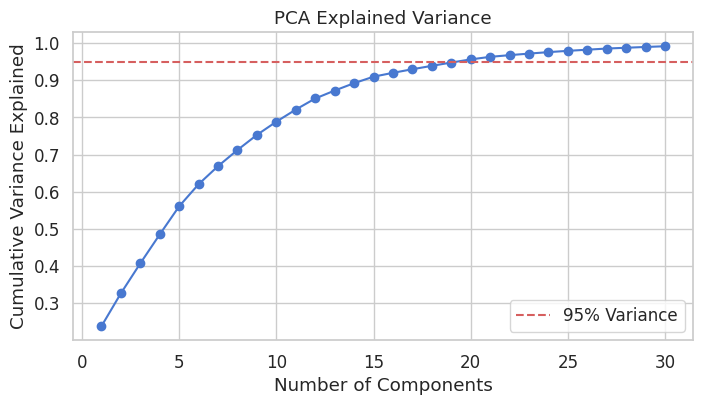

Selected n_components: 15
Training OC-SVM on PCA features...

--- OC-SVM on PCA Data (n=15) ---
              precision    recall  f1-score   support

      Normal       0.48      0.79      0.60      2152
     Anomaly       0.80      0.50      0.62      3674

    accuracy                           0.61      5826
   macro avg       0.64      0.64      0.61      5826
weighted avg       0.68      0.61      0.61      5826



In [44]:
# --- Task 3.5: PCA + OC-SVM ---

from sklearn.decomposition import PCA

# 1. PCA Analysis (Elbow Method)
# Fit on Normal Training Data Only
pca_test = PCA(n_components=30) # Test top 30 components first
pca_test.fit(X_train_normal)

# Plot Explained Variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), np.cumsum(pca_test.explained_variance_ratio_), marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.title("PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.show()

# 2. Apply PCA with Chosen Components
# Looking at the plot (once generated), usually 10-15 components explain 95%
best_n_components = 15
print(f"Selected n_components: {best_n_components}")

pca = PCA(n_components=best_n_components)
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test.values) # Transform test using same PCA

# 3. Train OC-SVM on PCA Features
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
print("Training OC-SVM on PCA features...")
ocsvm_pca.fit(X_train_pca)

# 4. Evaluate
y_pred_pca_raw = ocsvm_pca.predict(X_test_pca)
y_pred_pca = [1 if p == -1 else 0 for p in y_pred_pca_raw]

print(f"\n--- OC-SVM on PCA Data (n={best_n_components}) ---")
print(classification_report(y_test_binary, y_pred_pca, target_names=['Normal', 'Anomaly']))

#### Q: compare results with the original OC-SVM and the OC-SVM trained using the Encoder embeddings. Describe the performance...

TODO

## Task 4 - Unsupervised Anomaly Detection and Interpretation

text

In [45]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### K-means with little domain knowledge

Fit k-means with 4 clusters and the full training data (normal + anomalous). (Normal + 3 attack types = 4 clusters).

In [46]:
# [CODE BLOCK]
# 1. Use the *full preprocessed training data*
# 2. Fit a KMeans model with n_clusters=4
# 3. Get the cluster assignments (labels) for all training data

### K-means cluster interpretation

Examine the clusters to understand their quality.

In [47]:
# [CODE BLOCK]
# 1. Add the K-means cluster labels to the training dataframe (which has the real attack labels)
# 2. Calculate and print the size of each cluster
# 3. Create a contingency table (crosstab) of K-means clusters vs. true 'attack_label'
# 4. Calculate silhouette scores per cluster

#### Q: How big are the clusters? How are the attack labels distributed across the clusters? Are the clusters pure?

TODO

#### Q: How high is the silhouette per cluster? Is there any clusters with a lower silhouette value? If it is the case, what attack labels are present in these clusters?

TODO

#### Q: Use the t-SNE algorithm... Plot and report: i) t-SNE... with cluster ID. ii) t-SNE... with the attack label.

TODO

In [48]:
# [CODE BLOCK]
# 1. Run t-SNE on the full training data (n_components=2)
#    - Try a few perplexity values (e.g., 30, 50, 100)
# 2. Choose the best-looking perplexity
# 3. Plot 1: 2D t-SNE scatter plot, colored by *K-means cluster ID*
# 4. Plot 2: 2D t-SNE scatter plot, colored by *true attack_label*

#### Q: Can you find a difference between the two visualizations? What are the misinterpreted points?

TODO

### DB-Scan anomalies are anomalies?

Use DB-Scan to detect anomalous patterns.

In [49]:
# [CODE BLOCK]
# 1. Determine 'min_points'
#    - (Justify your choice. e.g., "From the k-means analysis, the smallest 'pure' normal cluster was not found. We will set min_points=... based on domain knowledge/heuristics...")
# 2. Determine 'eps' (e) using the elbow rule
#    - Calculate distance to the k-th nearest neighbor (k=min_points)
#    - Sort and plot these distances
#    - Find the 'elbow' (point of max curvature)
# 3. Run DBSCAN on the full training set with your chosen 'eps' and 'min_points'
# 4. Get the DBSCAN cluster labels (includes -1 for noise)
# 5. Check the noise cluster (label -1)
# 6. Create a crosstab of DBSCAN cluster labels vs. true 'binary_label' (0=normal, 1=anomaly)

#### Q: Create the clustering results... Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points (cross-reference with real attack labels)?

TODO

---